# Plasma PINN Project

In [1]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from utils.constants import *
from pinn_setup import PINN

rcParams['figure.dpi'] = 150

In [2]:
# Data storage variables
DATA_FILE_NAME = 'data/plasma_data.h5'
NT = 4
NX, NY = 128, 89
N_FRAME = NX * NY

# Plotting variables
SPACE_FACTOR = 100.0 * MINOR_RADIUS  # cm conversion
SCATTER_POINT_SIZE = 10

# Load Training Data

In [3]:
den_frames = []
Te_frames = []

vec_to_mat = lambda vec: np.fliplr(vec.reshape(NX,NY,order='F')).T

# Open file object with HDF5 datasets,
# each of shape (NT*N_FRAME, 1)
with h5py.File(DATA_FILE_NAME, 'r') as f:
    for frame_idx in range(NT):
        frame_idxs = range(
            frame_idx*N_FRAME,
            (frame_idx + 1)*N_FRAME
        )

        den_frames.append(
            vec_to_mat(f['y_den'][frame_idxs]) * PLASMA_DENSITY
        )
        Te_frames.append(
            vec_to_mat(f['y_Te'][frame_idxs]) * ELECTRON_TEMP
        )
        # # Extra, uneeded
        # t = f['x_t'][frame_idxs[0]] # Time of frame (s?)
        # z = f['x_z'][frame_idxs] # z location of frame (units?)
        # Ti = f['y_Ti'][frame_idxs] * ION_TEMP
    
    # Constant grid over time
    xx = vec_to_mat(f['x_x'][frame_idxs]) * SPACE_FACTOR
    yy = vec_to_mat(f['x_y'][frame_idxs]) * SPACE_FACTOR

In [4]:
x_min = np.min(xx)
x_max = np.max(xx)
y_min = np.min(yy)
y_max = np.max(yy)

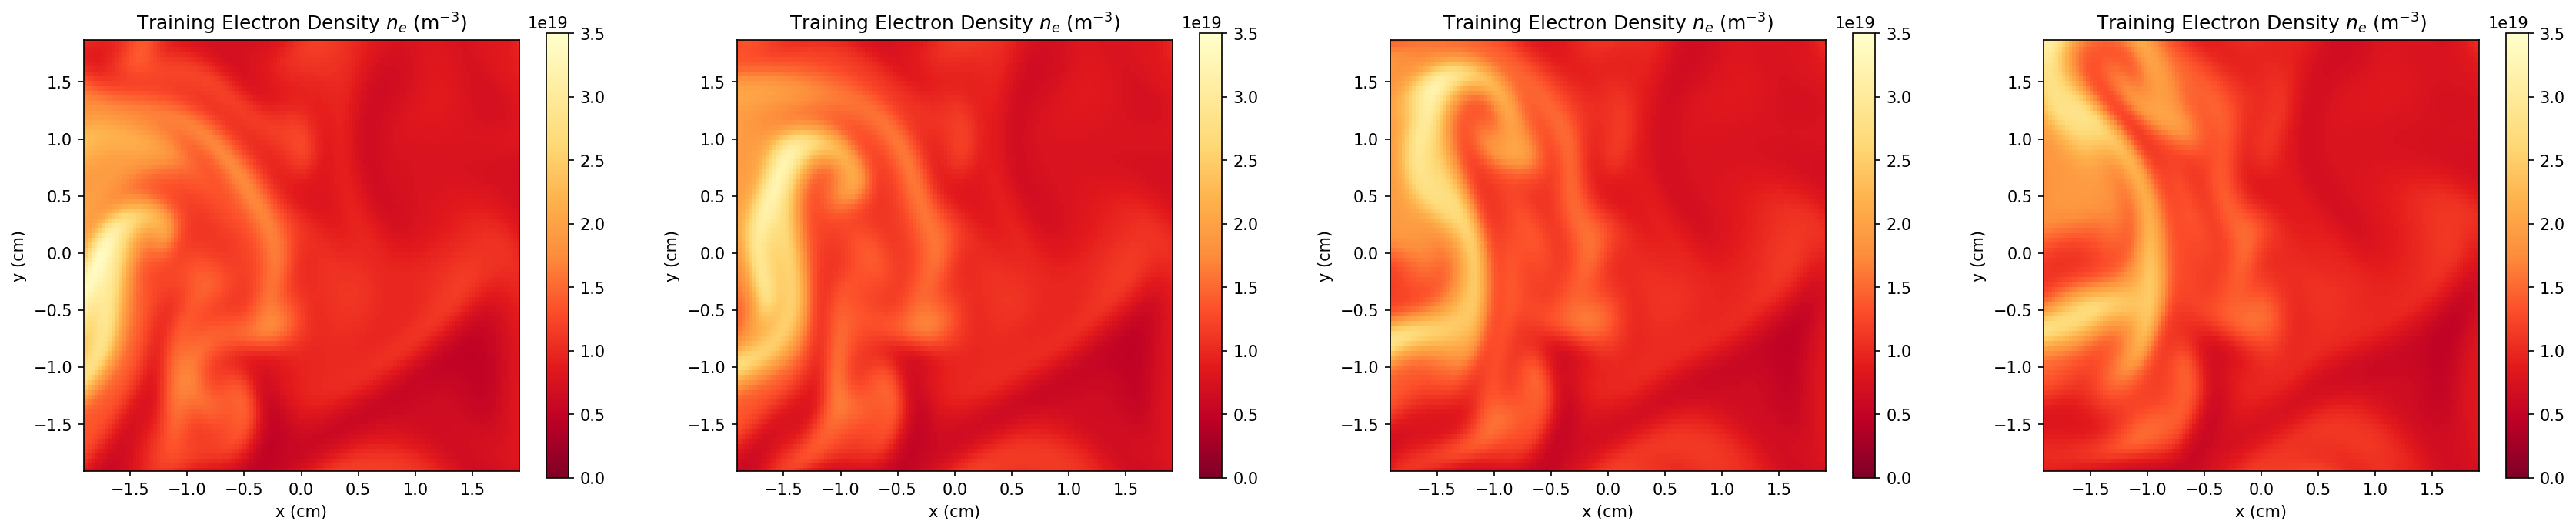

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=NT, figsize=(7*NT,5))

for i in range(NT):
    im = ax[i].pcolor(
        xx, yy, den_frames[i],
        vmin=0, vmax=3.5e19, cmap='YlOrRd_r'
    )
    cb = plt.colorbar(im)

    ax[i].set_xlim(x_min, x_max)
    ax[i].set_ylim(y_min, y_max)
    ax[i].set_xlabel('x (cm)')
    ax[i].set_ylabel('y (cm)')
    ax[i].set_title('Training Electron Density $n_e$ (m$^{-3}$)')
    
    ax[i].set_aspect('equal')

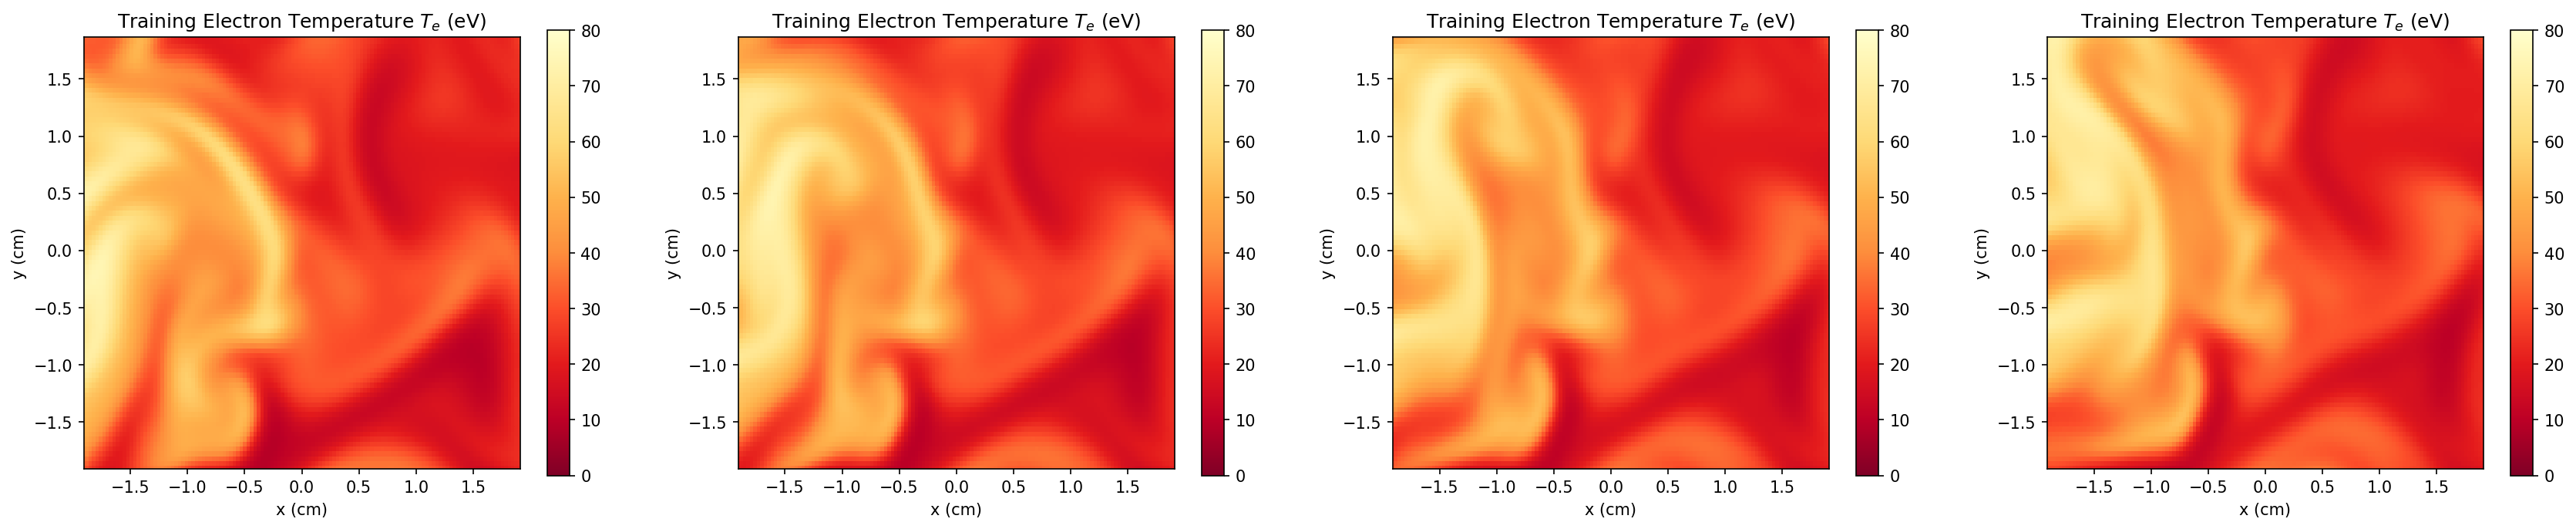

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=NT, figsize=(7*NT,5))

for i in range(NT):
    im = ax[i].pcolor(
        xx, yy, Te_frames[i],
        vmin=0, vmax=80,
        cmap='YlOrRd_r'
    )
    cb = plt.colorbar(im)
    ax[i].set_xlim(x_min, x_max)
    ax[i].set_ylim(y_min, y_max)
    ax[i].set_xlabel('x (cm)')
    ax[i].set_ylabel('y (cm)')
    ax[i].set_title('Training Electron Temperature $T_e$ (eV)')
    
    ax[i].set_aspect('equal')

# Train PINN

In [6]:
# Define known solutions
def v1_true(x, y, t):
    return np.sin(np.pi * x) * np.cos(np.pi * y) * np.exp(-t)

def v5_true(x, y, t):
    return np.cos(np.pi * x) * np.sin(np.pi * y) * np.exp(-t)

# Generate synthetic training data
N = 1000
x = np.random.rand(N, 1)
y = np.random.rand(N, 1)
t = np.random.rand(N, 1)
v1 = v1_true(x, y, t)
v5 = v5_true(x, y, t)

# Define network
layers = [3, 64, 64, 64, 1]
model = PINN(x, y, t, v1, v5, layers=layers, use_pde=False)
model.setup_optimizers()
model.apply(model.xavier_init)

# Define loss
loss_fn = torch.nn.MSELoss()

# Train
print(
    'Epoch\t| Var 1 Train Loss\t| Var 5 Train Loss\t| '
    'Total Train Loss'
)
for epoch in range(1000):
    loss = model.train_step(
        loss_fn, model.optimizer_v1, model.optimizer_v5
    )
    if epoch % 100 == 0:
        print(
            f'{epoch:3d}\t| {loss["v1"]:.2e}\t\t| '
            f'{loss["v5"]:.2e}\t\t| {loss["total"]:.2e}'
        )

Epoch	| Var 1 Train Loss	| Var 5 Train Loss	| Total Train Loss
  0	| 9.83e-02		| 1.64e-01		| 2.62e-01
100	| 6.99e-03		| 1.28e-02		| 1.98e-02
200	| 1.53e-03		| 2.60e-03		| 4.13e-03
300	| 6.82e-04		| 1.12e-03		| 1.80e-03
400	| 4.00e-04		| 6.69e-04		| 1.07e-03
500	| 2.75e-04		| 3.84e-04		| 6.59e-04
600	| 1.77e-04		| 2.42e-04		| 4.19e-04
700	| 1.45e-04		| 2.10e-04		| 3.55e-04
800	| 1.41e-04		| 1.55e-04		| 2.96e-04
900	| 1.11e-04		| 1.18e-04		| 2.29e-04


In [7]:
# Generate test data on a grid
x_test, y_test, t_test = np.meshgrid(
    np.linspace(0, 1, 20),
    np.linspace(0, 1, 20),
    np.linspace(0, 1, 5)
)
x_test = x_test.flatten()[:, None]
y_test = y_test.flatten()[:, None]
t_test = t_test.flatten()[:, None]

# Make predictions
preds = model.predict(x_test, y_test, t_test)
v1_pred = preds['v1']
v5_pred = preds['v5']

# Compute true values
v1_true_vals = v1_true(x_test, y_test, t_test)
v5_true_vals = v5_true(x_test, y_test, t_test)

# Evaluate Mean Squared Error
mse_v1 = np.mean((v1_pred - v1_true_vals)**2)
mse_v5 = np.mean((v5_pred - v5_true_vals)**2)

print(f'Test MSE for v1: {mse_v1:.3e}')
print(f'Test MSE for v5: {mse_v5:.3e}')

Test MSE for v1: 3.195e-04
Test MSE for v5: 3.683e-04


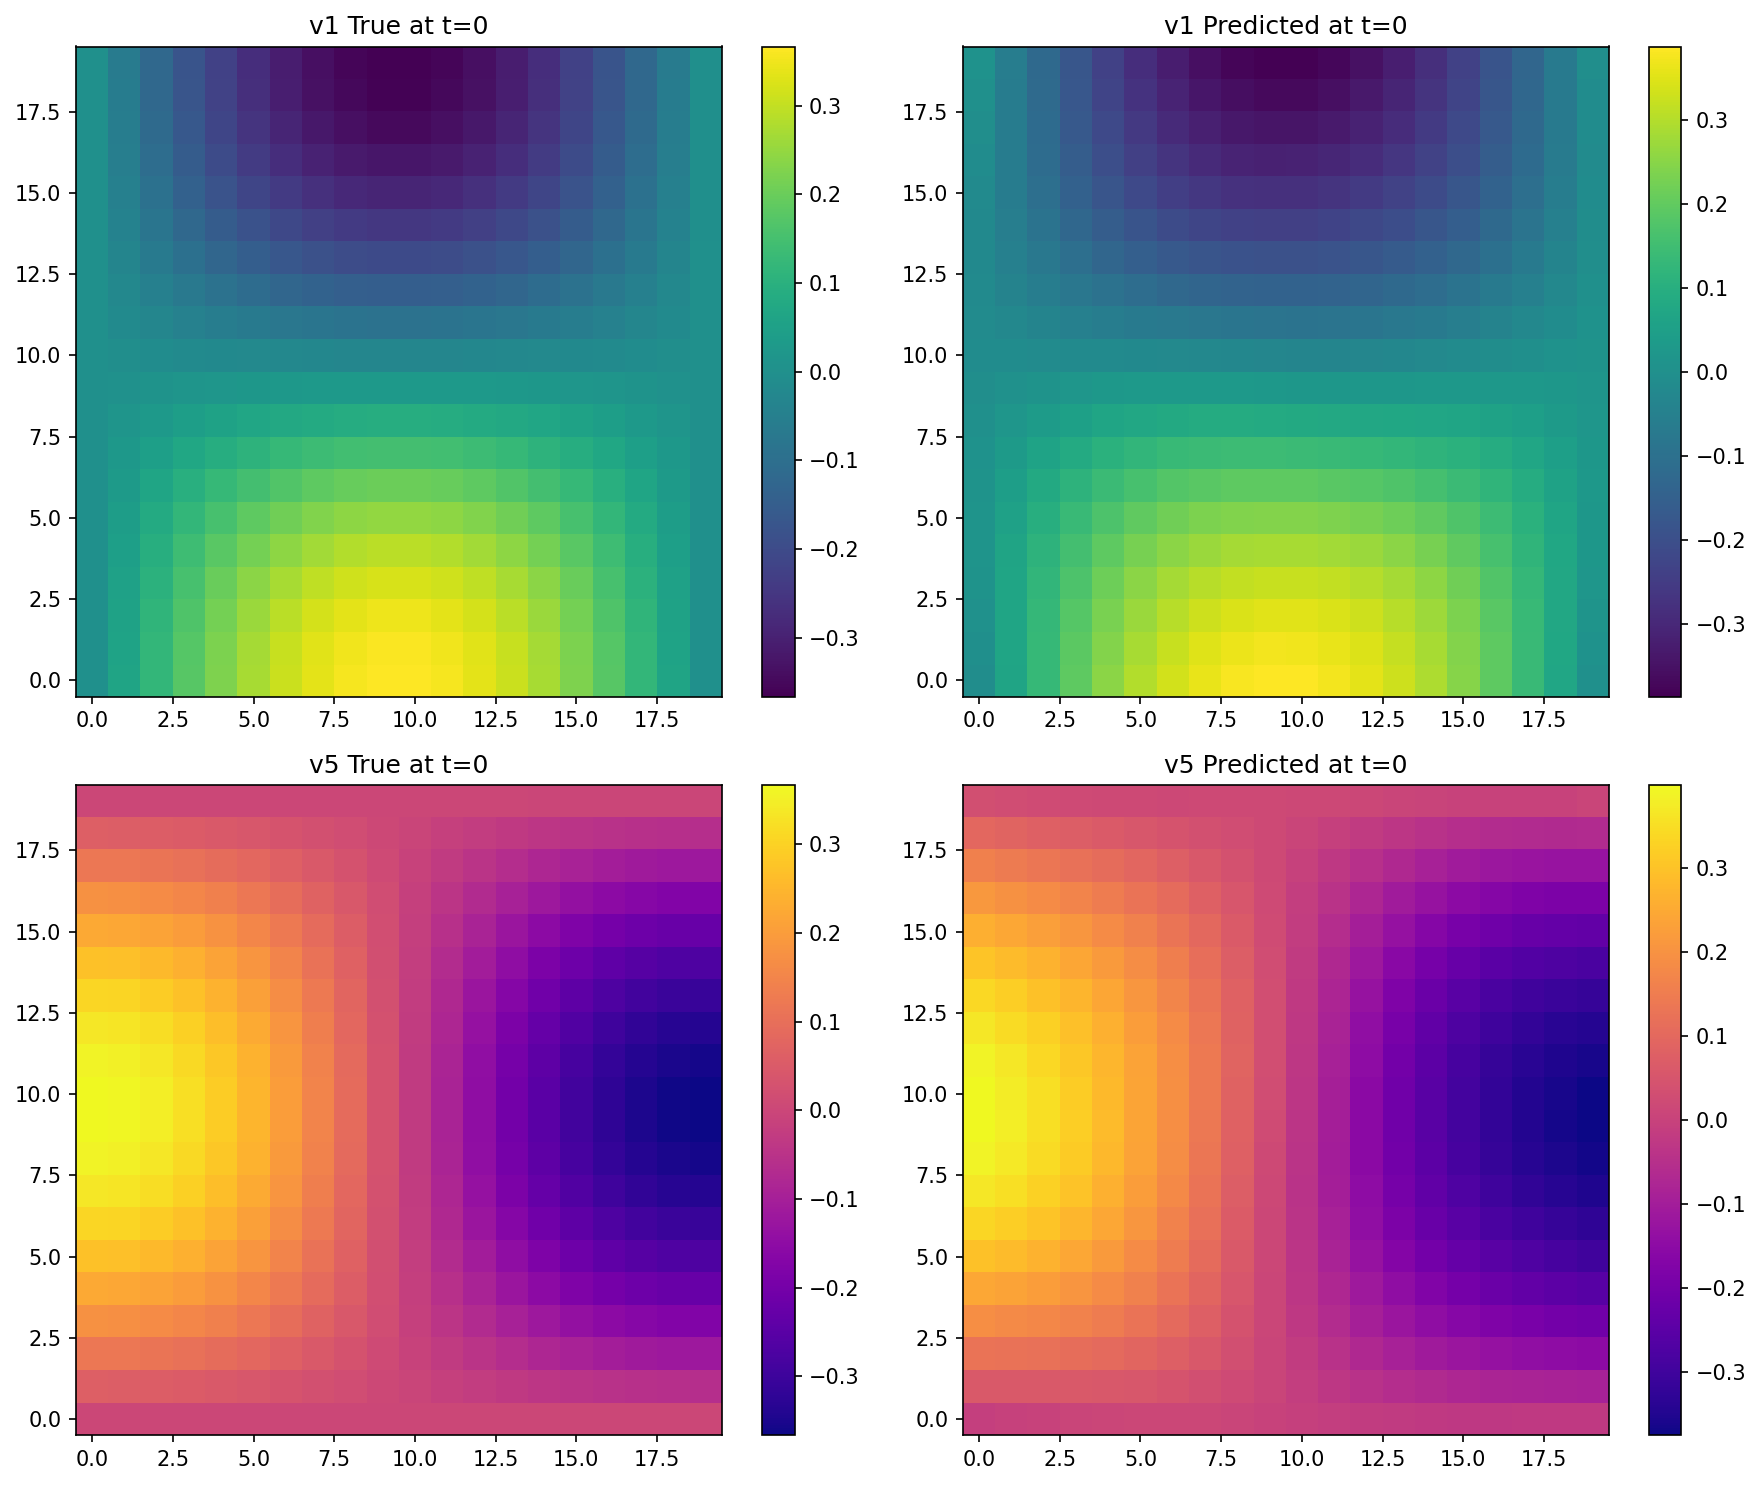

In [8]:
# Filter t = 0 slice (assumes t_test was from np.meshgrid)
mask = np.abs(t_test[:, 0] - 1.0) < 1e-6
x_slice = x_test[mask][:, 0]
y_slice = y_test[mask][:, 0]

# Determine grid shape
nx = len(np.unique(x_slice))
ny = len(np.unique(y_slice))

# Reshape for imshow
def reshape_field(field_1d):
    return field_1d.reshape(ny, nx)

v1_true_grid = reshape_field(v1_true_vals[mask][:, 0])
v1_pred_grid = reshape_field(preds['v1'][mask][:, 0])
v5_true_grid = reshape_field(v5_true_vals[mask][:, 0])
v5_pred_grid = reshape_field(preds['v5'][mask][:, 0])

# Plot heatmaps
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

im0 = axs[0, 0].imshow(v1_true_grid, origin='lower', cmap='viridis', aspect='auto')
axs[0, 0].set_title("v1 True at t=0")
plt.colorbar(im0, ax=axs[0, 0])

im1 = axs[0, 1].imshow(v1_pred_grid, origin='lower', cmap='viridis', aspect='auto')
axs[0, 1].set_title("v1 Predicted at t=0")
plt.colorbar(im1, ax=axs[0, 1])

im2 = axs[1, 0].imshow(v5_true_grid, origin='lower', cmap='plasma', aspect='auto')
axs[1, 0].set_title("v5 True at t=0")
plt.colorbar(im2, ax=axs[1, 0])

im3 = axs[1, 1].imshow(v5_pred_grid, origin='lower', cmap='plasma', aspect='auto')
axs[1, 1].set_title("v5 Predicted at t=0")
plt.colorbar(im3, ax=axs[1, 1])

plt.tight_layout()
plt.show()